In [1]:
import traceback
import numpy as np

import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

import datetime
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

sns.set_context('notebook')
sns.set_style("ticks")

In [3]:
# path="datafolder/tfevents/MNIST/CW20-0.1/base_adversarial/version_0" #folderpath

# dataset = 'MNIST'
# folder_pth = 'datafolder/tfevents/MNIST/'
dataset = 'CIFAR'
folder_pth = 'datafolder/tfevents/CIFAR/'

save_images = True
save_pth = 'imgs/traintimes/'

In [4]:

# Extraction function


def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": [], "wall_time": [], "epoch": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            wall_time = list(map(lambda x: x.wall_time, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step, "wall_time": wall_time, "epoch": np.arange(stop=len(step))}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
            
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data



In [5]:
def filter_rows_by_values(df, col, values):
    return df.query('metric in @values')


In [6]:
once = True

all_dict = []


    

for _attack_id in os.listdir(folder_pth):
    if os.path.isdir(folder_pth + _attack_id) and once:

        for _model_type in os.listdir(folder_pth + _attack_id):
            if os.path.isdir(folder_pth + _attack_id + '/' + _model_type) and once:

                for _run_version in os.listdir(folder_pth + _attack_id + '/' + _model_type):
                    if os.path.isdir(folder_pth + _attack_id + '/' + _model_type + '/' + _run_version) and once:

                        # Read log csv
                        _df = tflog2pandas(folder_pth + _attack_id + '/' + _model_type + '/' + _run_version)
                        _df = _df.convert_dtypes()
                        # Filter to only these metrics
                        _df = filter_rows_by_values(_df, 'metric', ['val_acc', 'val_adv_acc', 'train_adv_acc_epoch'])

                        for _metric in _df.metric.unique():
                            for value, step, epoch, wtime in zip(_df[_df.metric == _metric]['value'], _df[_df.metric == _metric]['step'], _df[_df.metric == _metric]['epoch'], _df[_df.metric == _metric]['wall_time']):
                                all_dict.append((_attack_id, _model_type, _run_version, _metric, step, epoch, wtime, value))
            # once = False

df_full = pd.DataFrame(all_dict, columns=["attack", "model", "run", "metric", "step", "epoch", "wall_time", "value"])                   



In [7]:
print(df_full.attack.unique())
print(df_full.model.unique())

['CW20-0.1' 'FGSM-RS' 'PGD5-0.4']
['base_adversarial' 'dream16itslr1e-3' 'dream4itslr1e-2' 'dream8itslr1e-2'
 'dream8itslr1e-3']


In [8]:
cifar_style = {
    'CW20-0.1': "CW$_{0.1}^{20}$",
    'FGSM-RS': "FGSM-RS",
    'PGD5-0.4': "PGD$_{0.012}^{5}$",

    'base_adversarial': "AT",
    'dream16itslr1e-3': "Dream-AT$_{0.001}^{16}$",
    'dream4itslr1e-2' : "Dream-AT$_{0.01}^{4}$",
    'dream8itslr1e-2': "Dream-AT$_{0.01}^{8}$",
    'dream8itslr1e-3': "Dream-AT$_{0.001}^{8}$"
}

mnist_style = {
    'CW20-0.1': "CW$_{0.1}^{20}$",
    'FGSM-RS': "FGSM-RS",
    'PGD5-0.4': "PGD$_{0.12}^{5}$",

    'base_adversarial': "AT",
    'dream4itslr1e-2': "Dream-AT$_{0.01}^{4}$",
    'dream4itslr1e-1' : "Dream-AT$_{0.1}^{4}$",
    'dream8itslr1e-1': "Dream-AT$_{0.1}^{8}$",
    'dream8itslr1e-2': "Dream-AT$_{0.01}^{8}$"
}

if 'MNIST' == dataset:
    style = mnist_style
else:
    style = cifar_style

df = df_full.copy()
df['model'] = df_full.apply(lambda row:  style[row['model']], axis=1)

In [9]:
def plot_attack(data, attack_id, conf_interval = ('ci', 0), save_file:bool = False):
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), sharey = True)
    titles = ["Adversarial training accuracy", "Adversarial validation accuracy", "Validation accuracy"]
    


    for ax_idx, valtype in enumerate(["train_adv_acc_epoch", "val_adv_acc", "val_acc"]):
        _ax = axs[ax_idx]


        # Select data from attack id, per model, per metric
        _df_data = data.loc[(data.attack == attack_id) & (data.metric == valtype)]
        # _df_data['combined_label'] = _df_data['model'] + _df_data['run']
        _df_data = _df_data.replace("AT", style[attack_id])

        sns.lineplot(x='epoch', y='value', data=_df_data, hue='model', ax=_ax, errorbar=conf_interval)
        # sns.lineplot(x='epoch', y='value', data=_df_data, hue='combined_label', ax=_ax)
        
        l = _ax.legend()
        l.set_title('')

        _ax.set_ylabel("accuracy")
        _ax.grid(visible=True)
        _ax.set_title(f"{titles[ax_idx]}")
        _ax.tick_params(axis='both', which='major', labelleft='True')

        if save_file:
            if type(conf_interval) is tuple:
                errstr = f"{conf_interval[0]}_{conf_interval[1]}"
            else:
                errstr = "minmax"
            fig.savefig(f"{save_pth}{dataset}_{attack_id}_err_{errstr}.pdf", dpi=300, format='pdf')

In [10]:
print(df.attack.unique())

['CW20-0.1' 'FGSM-RS' 'PGD5-0.4']


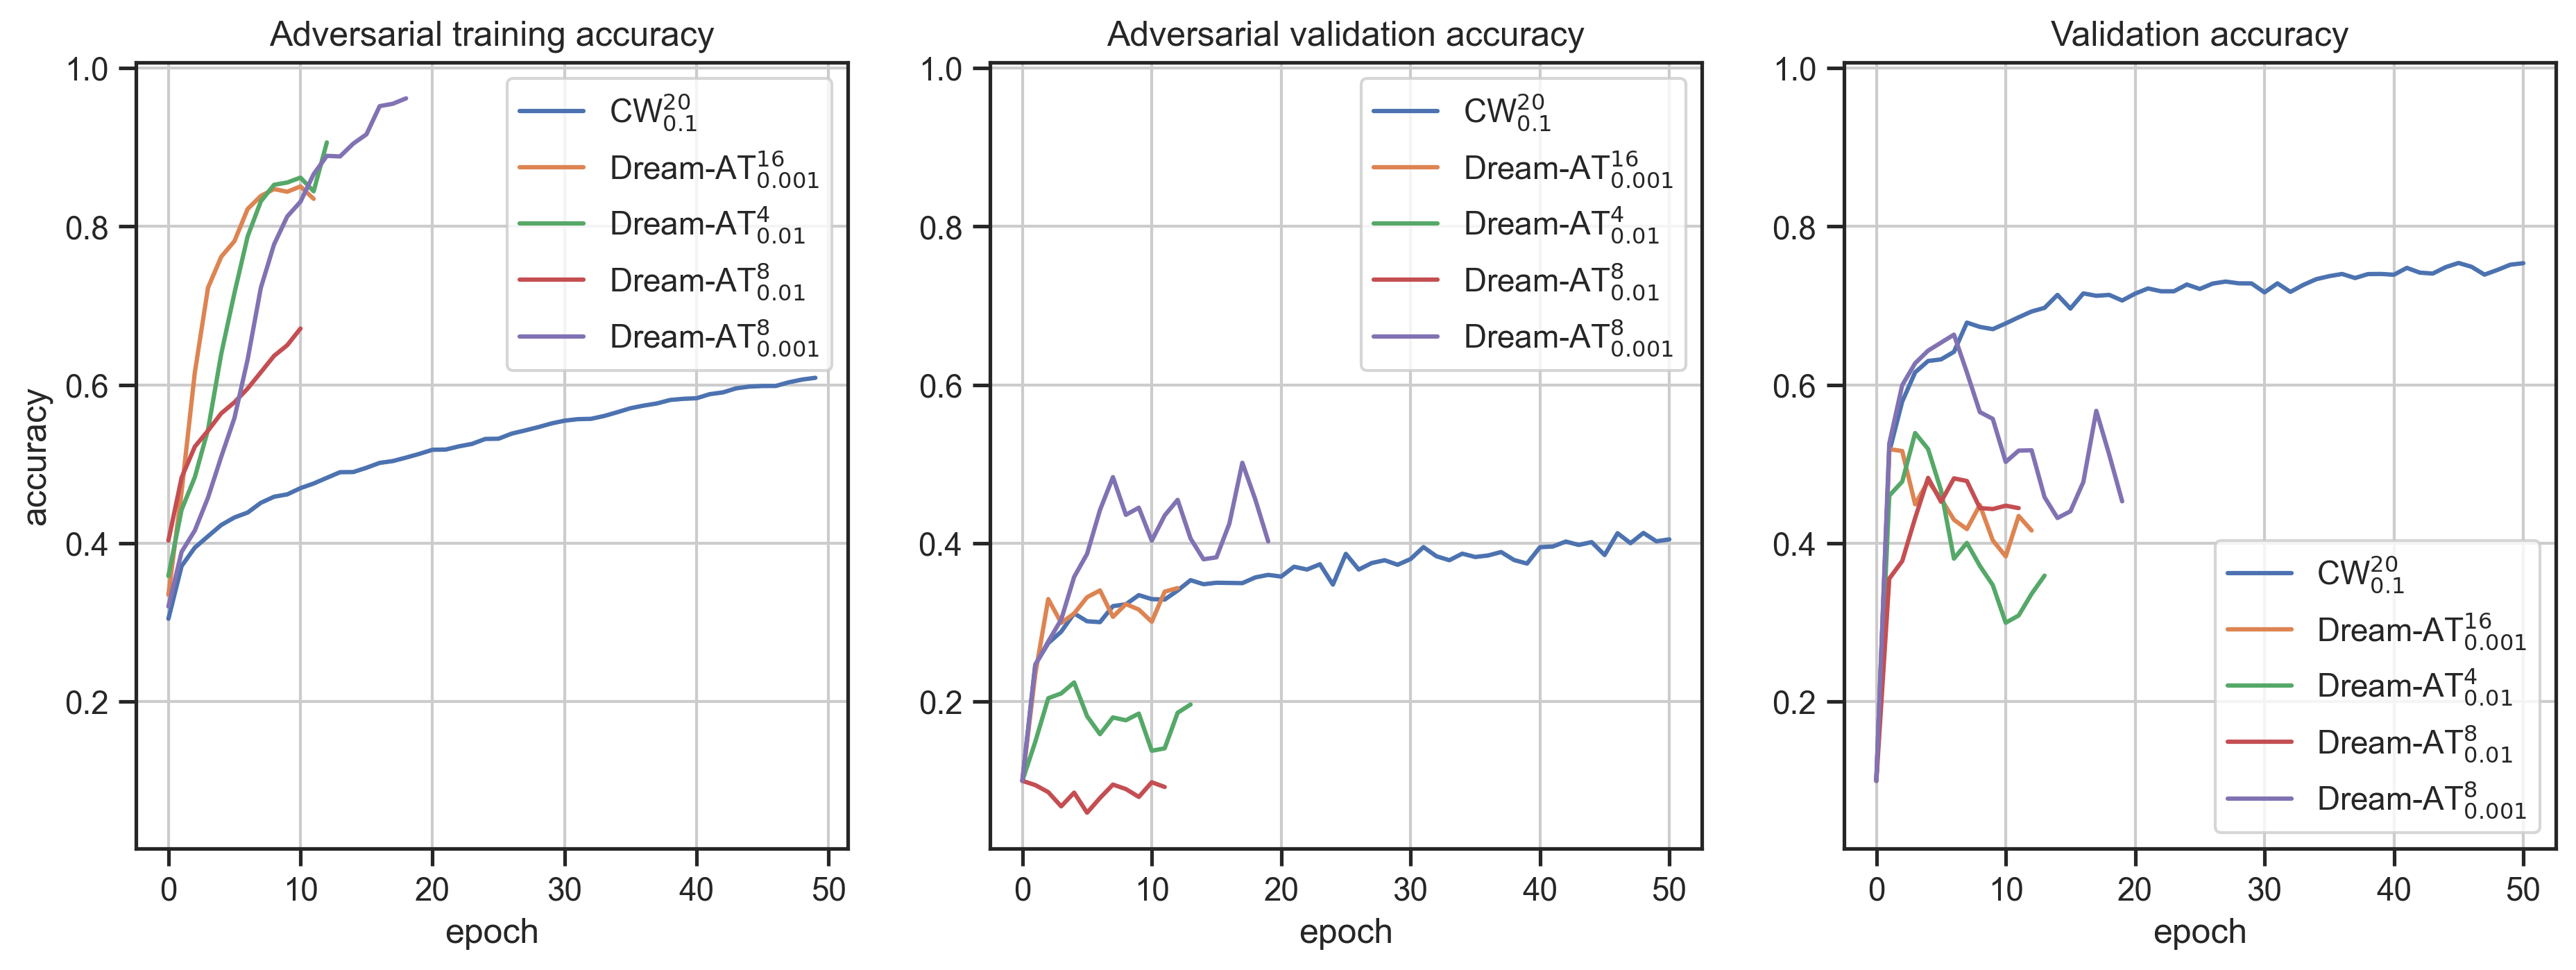

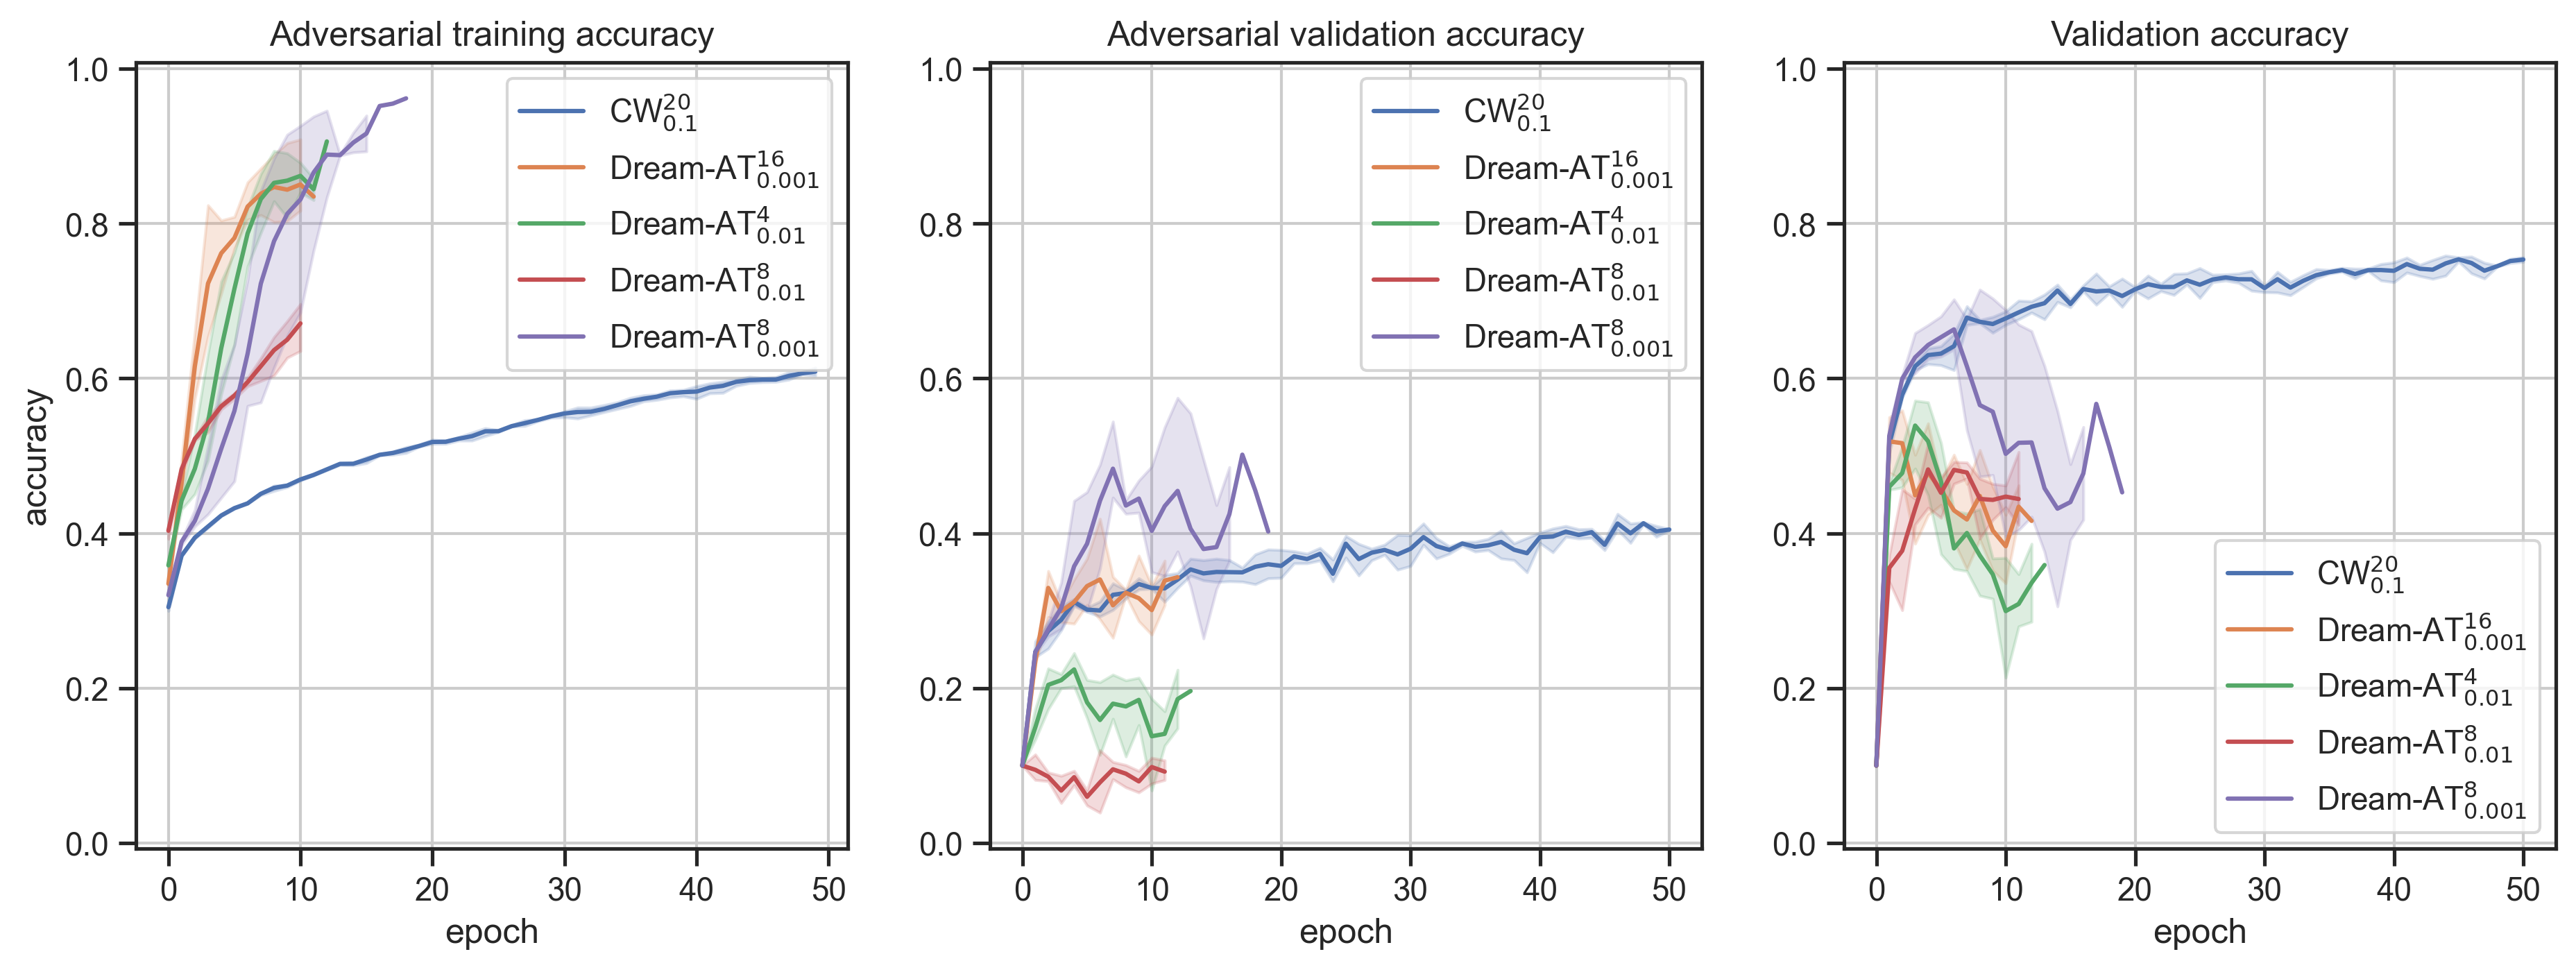

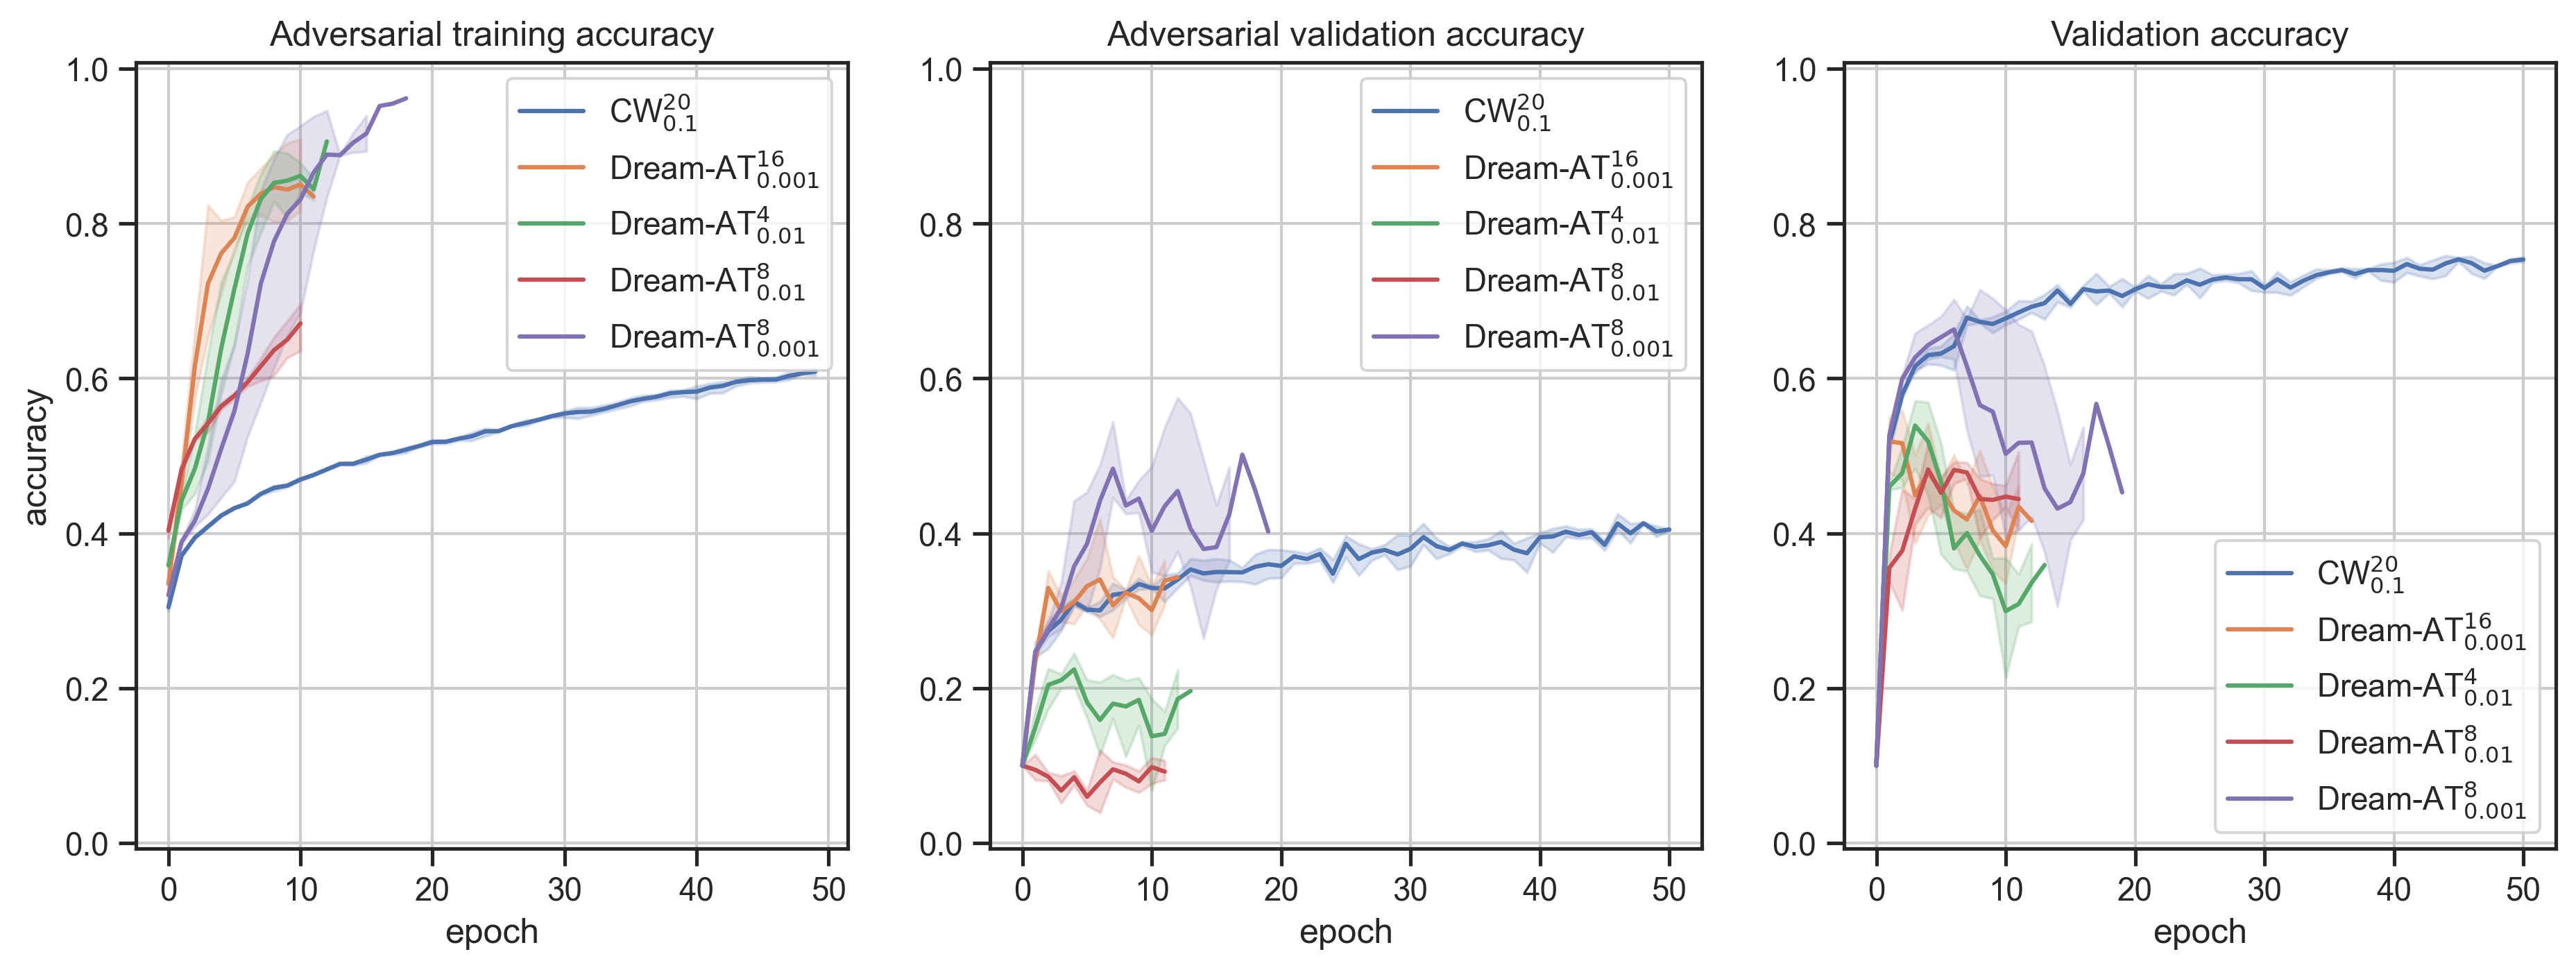

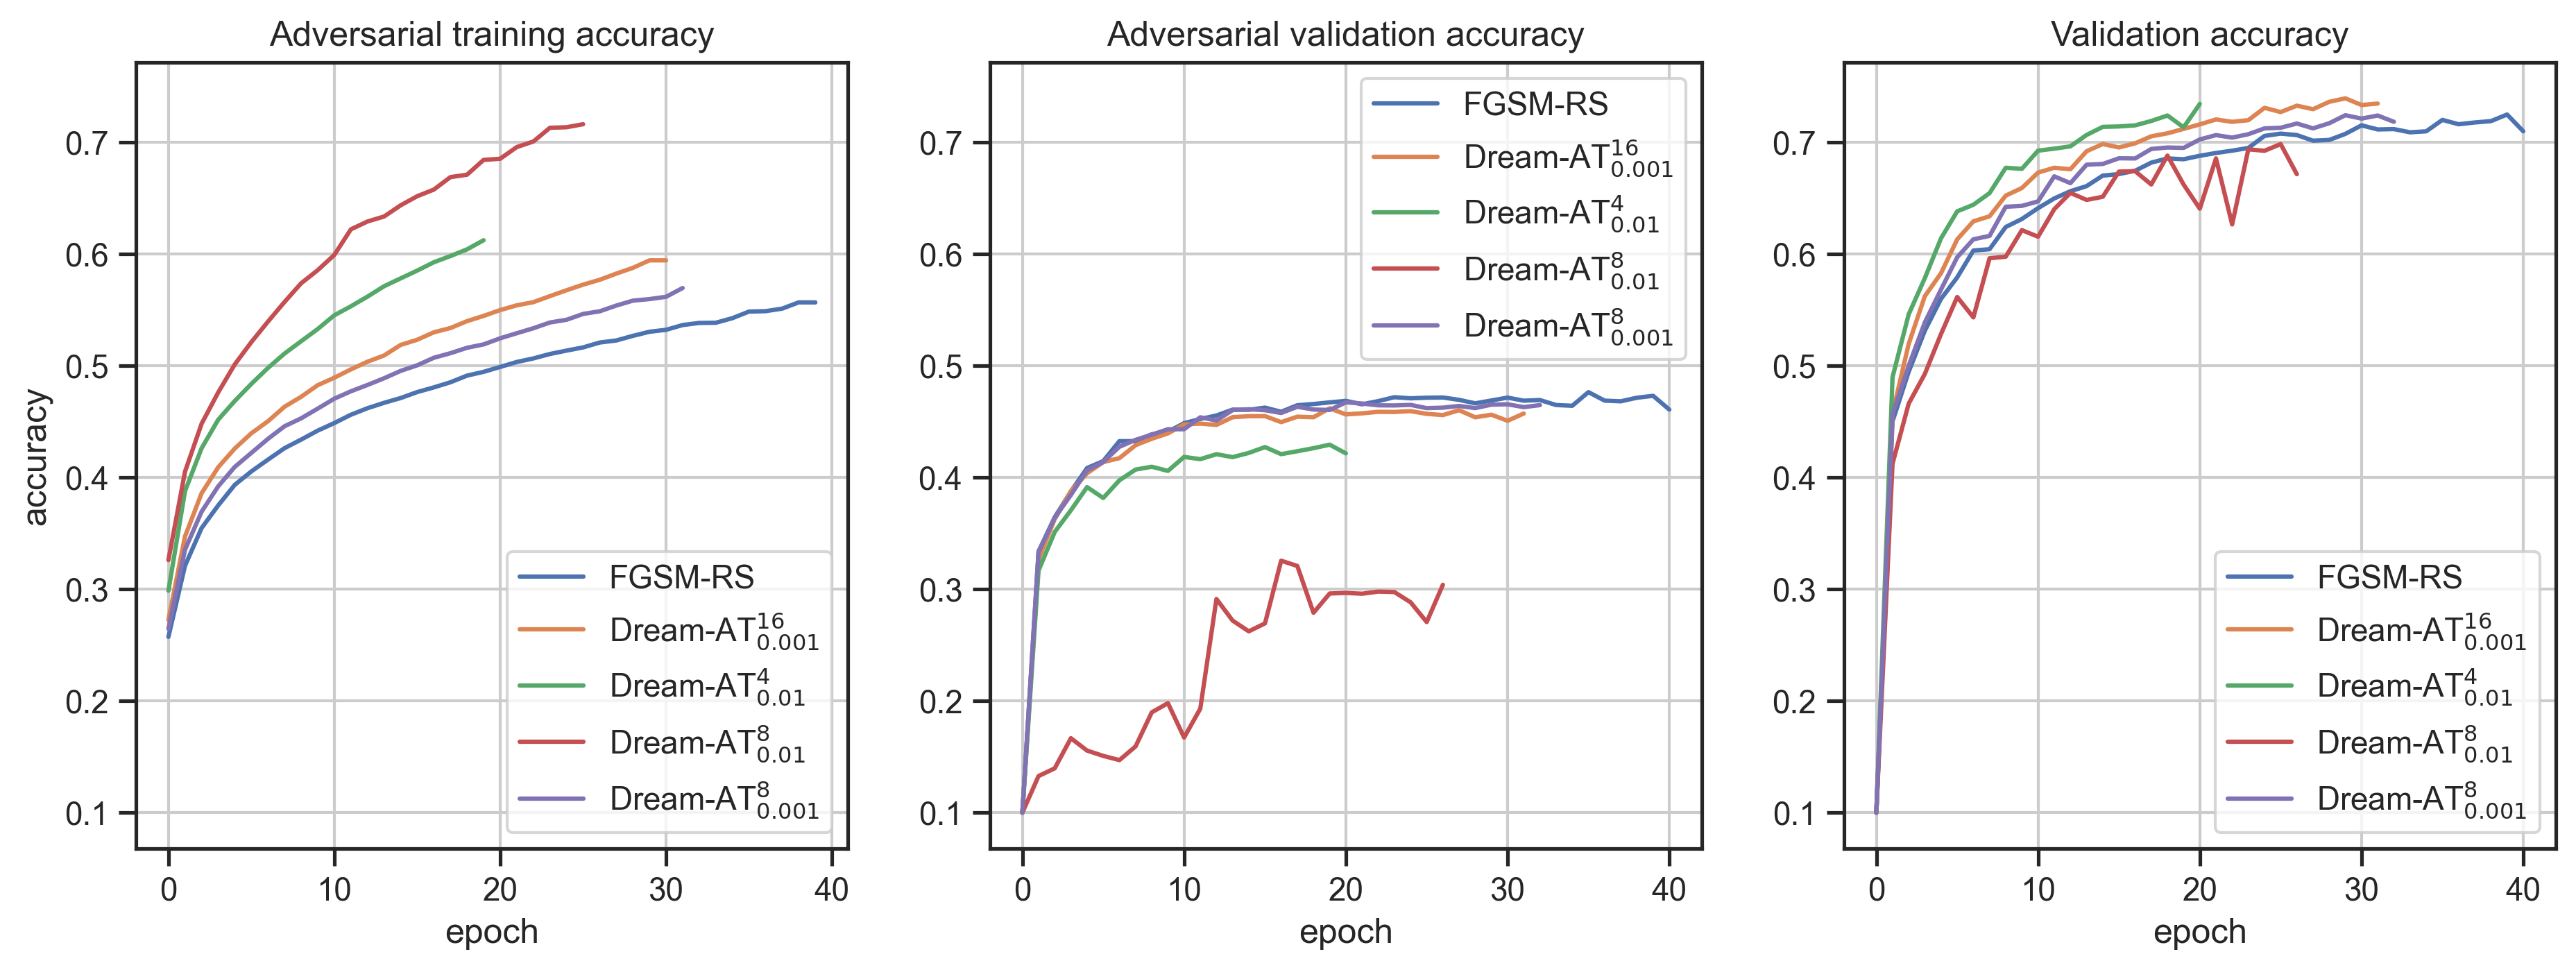

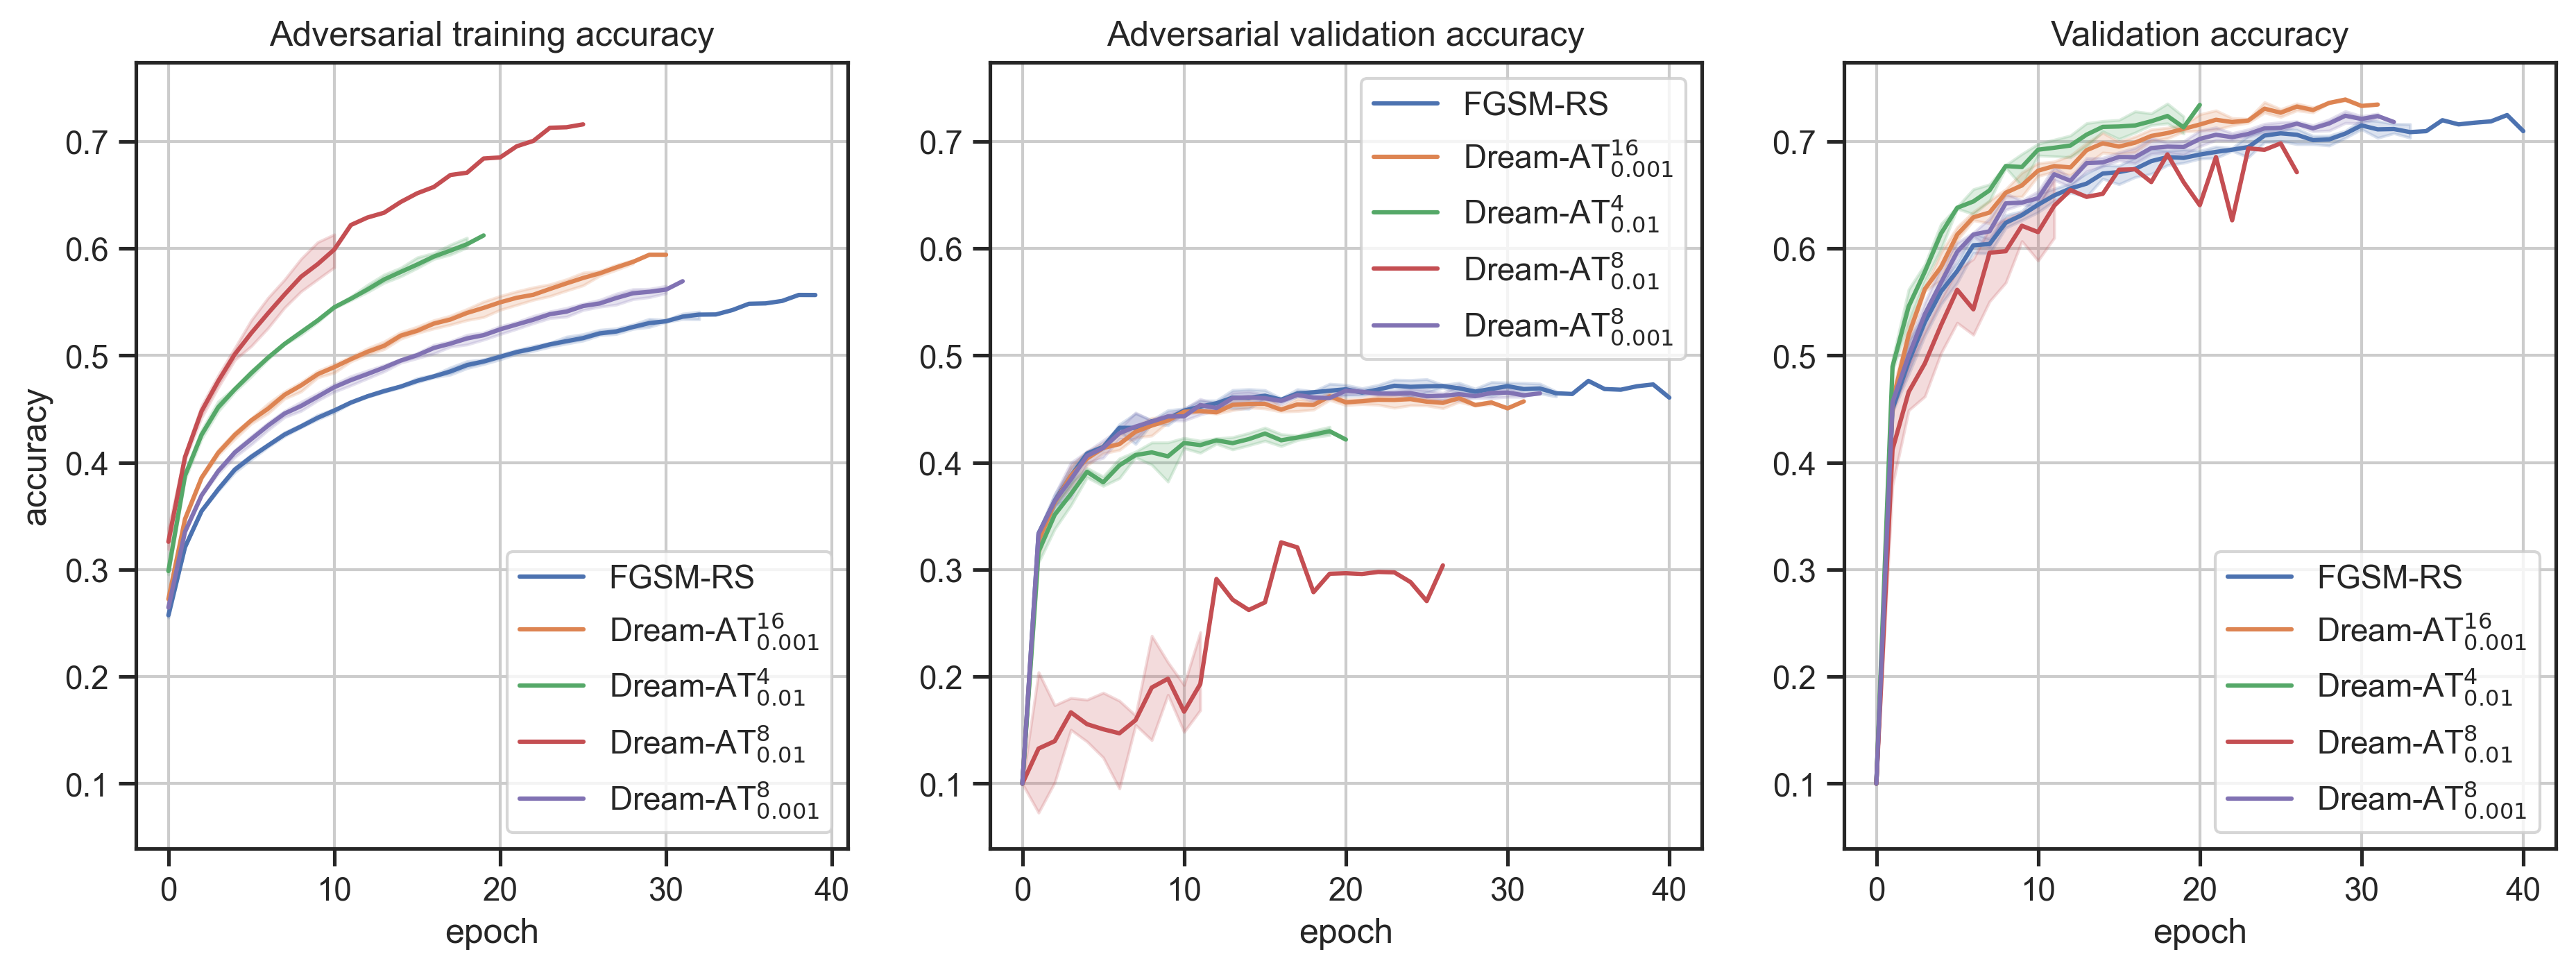

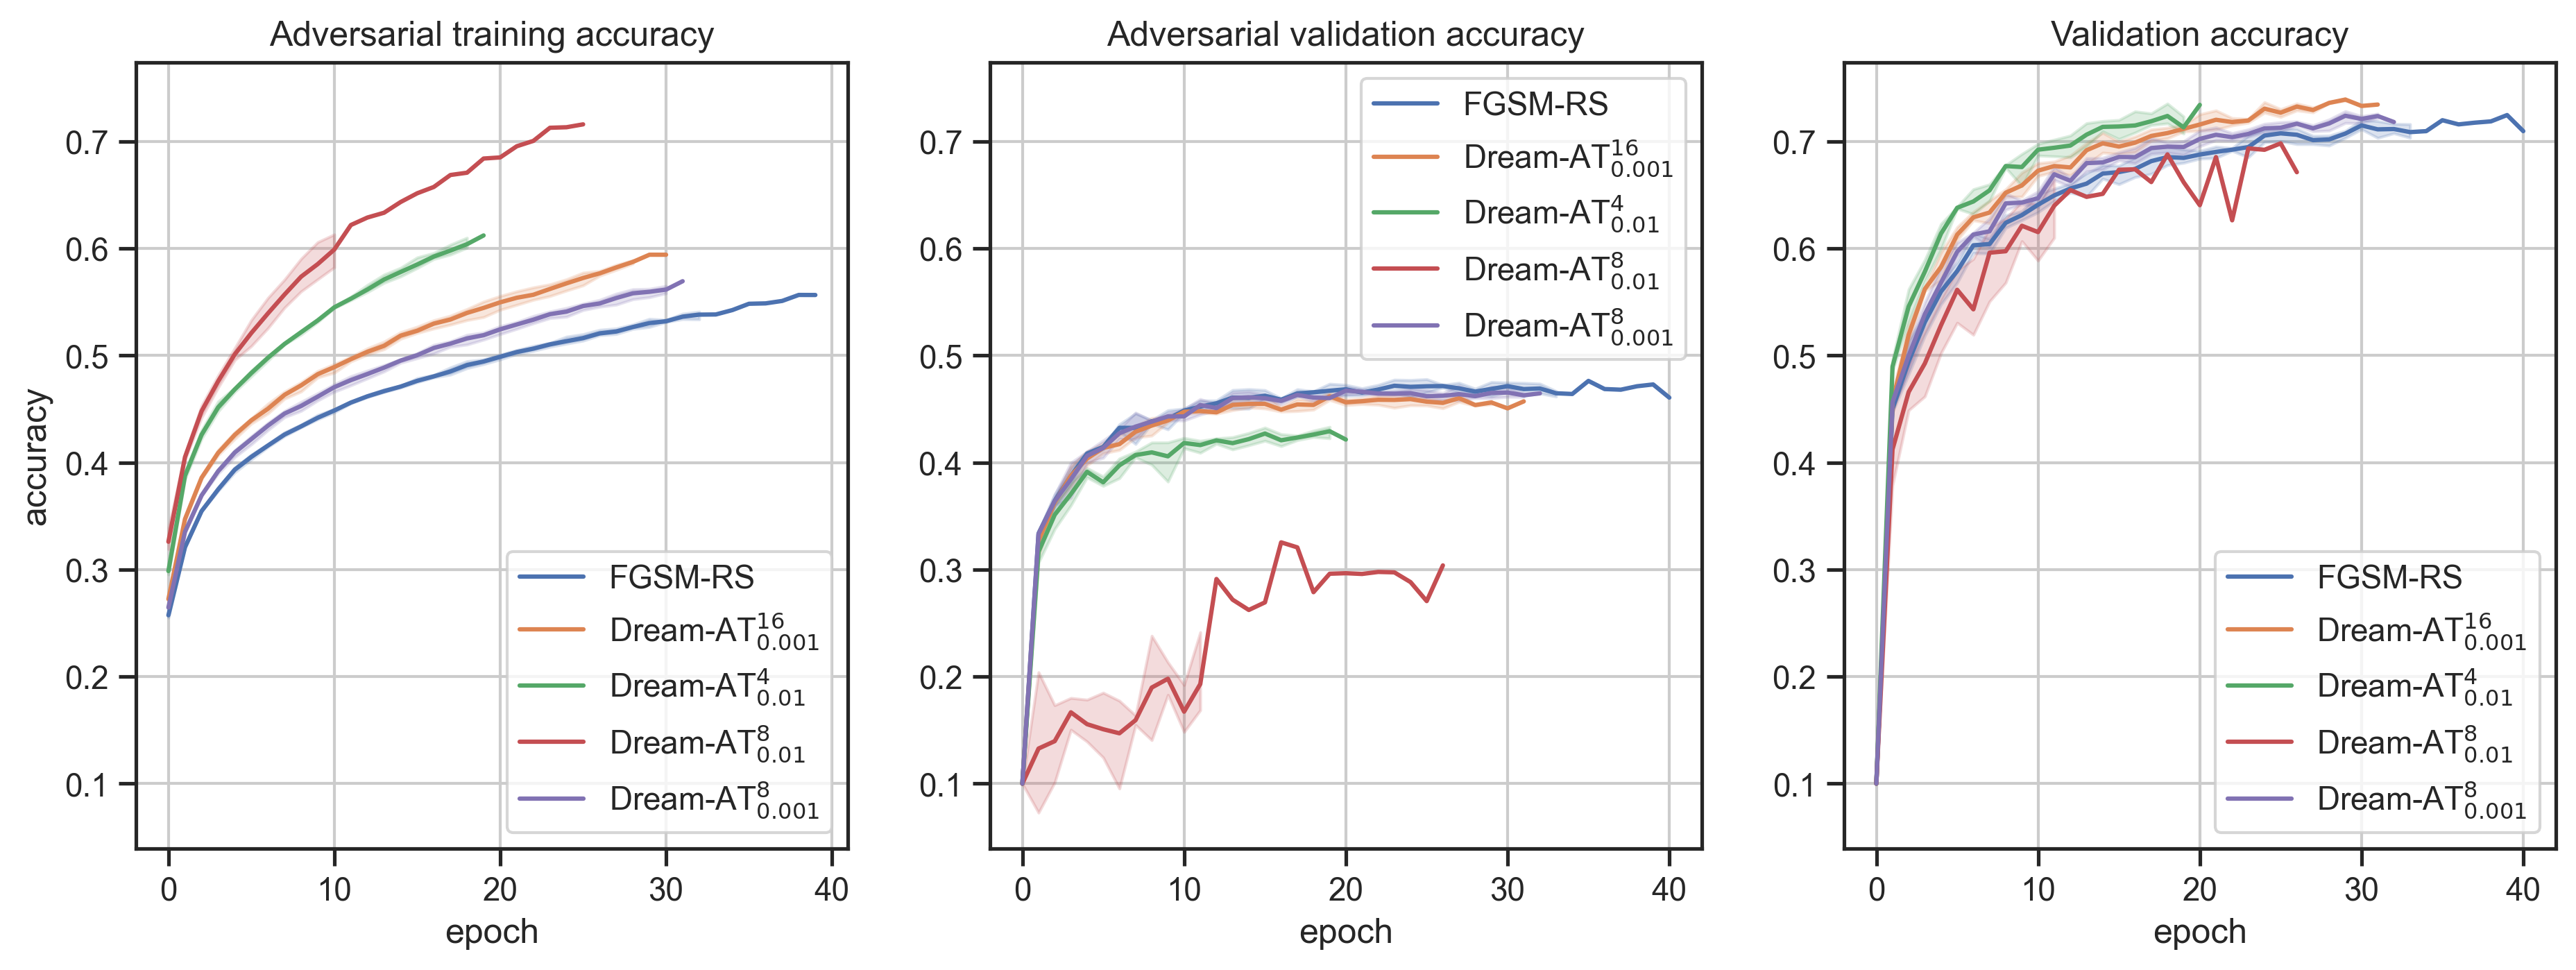

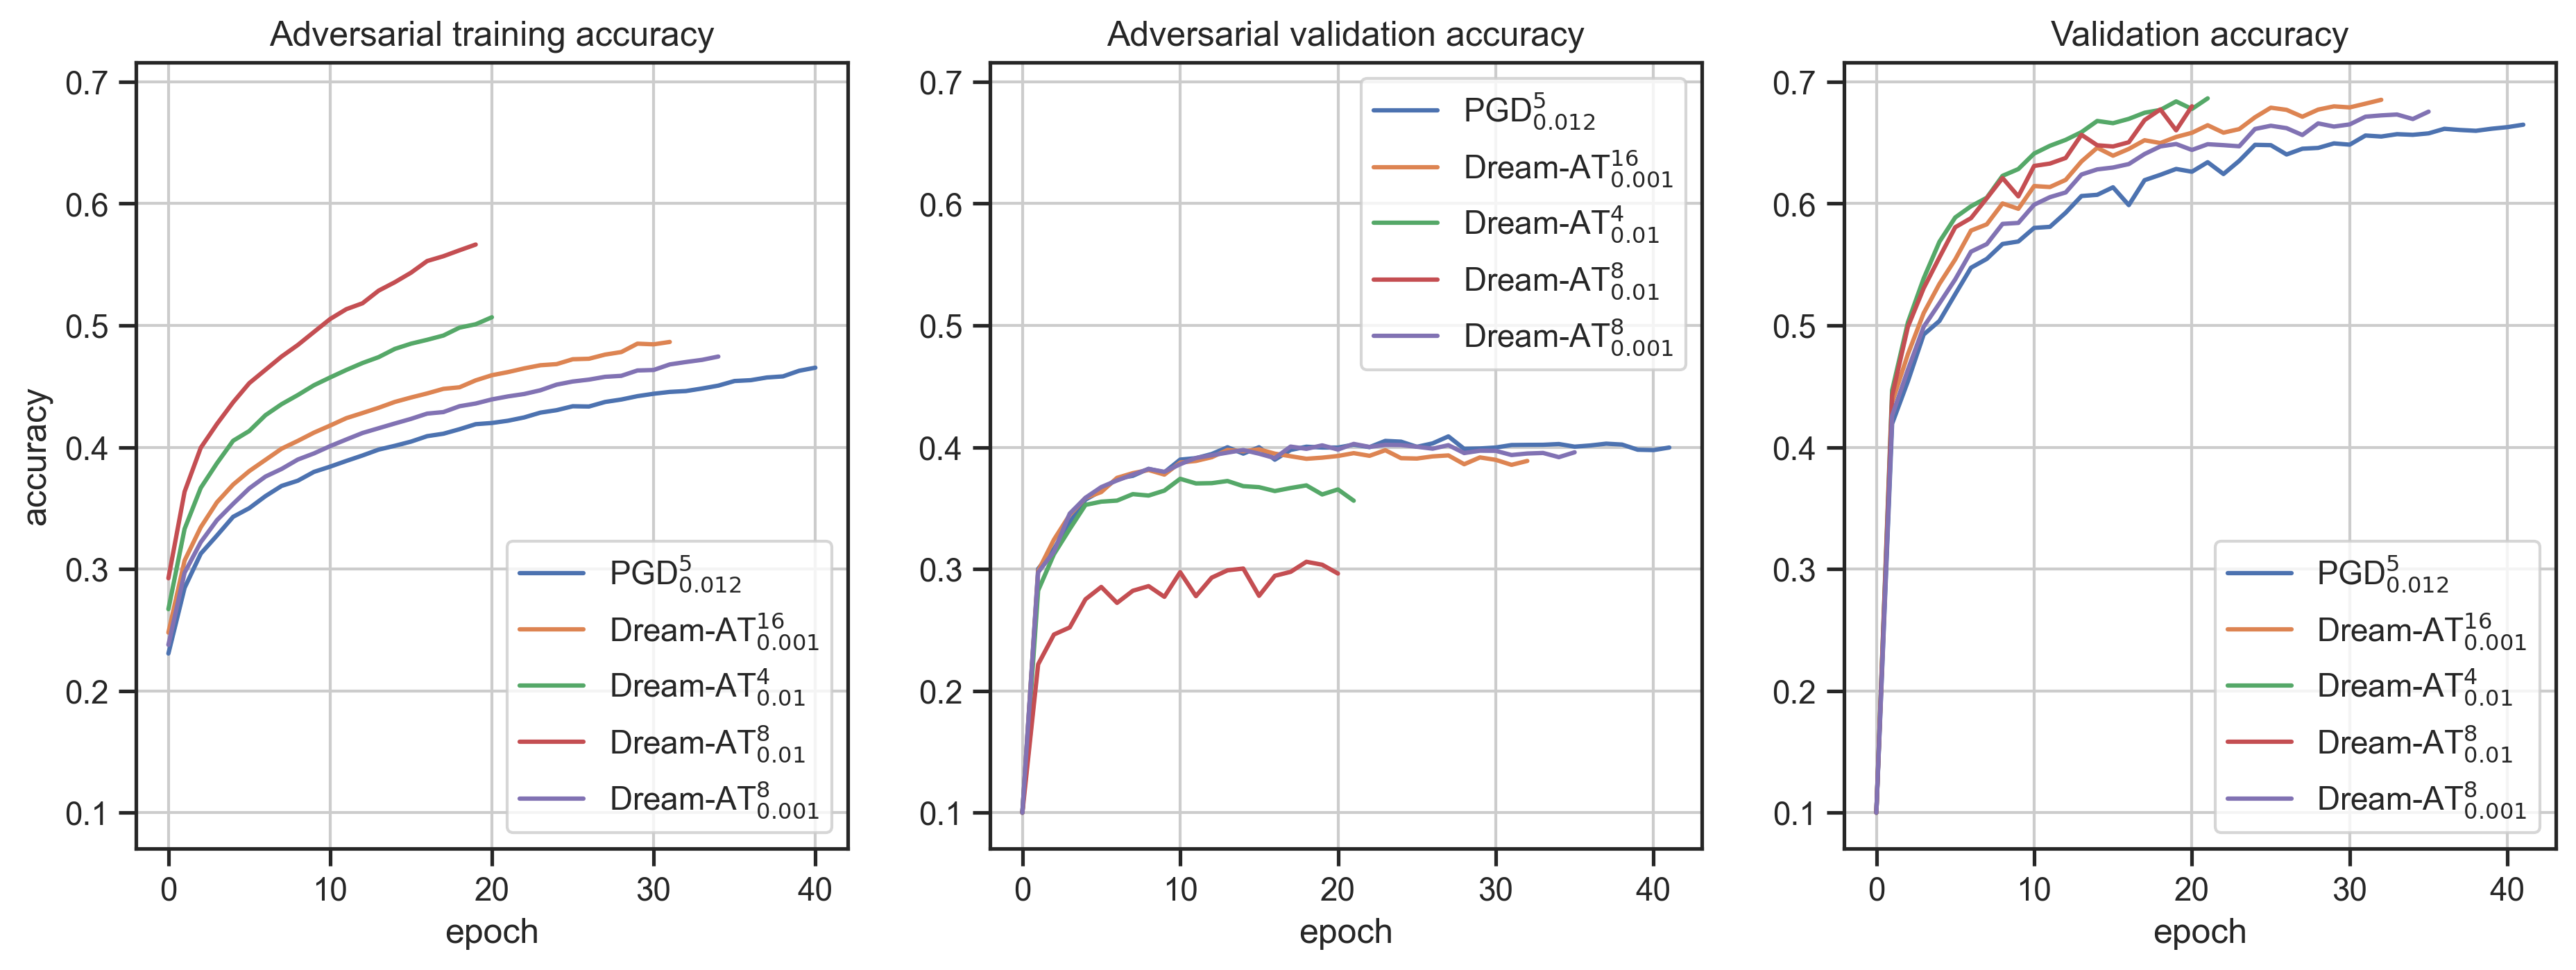

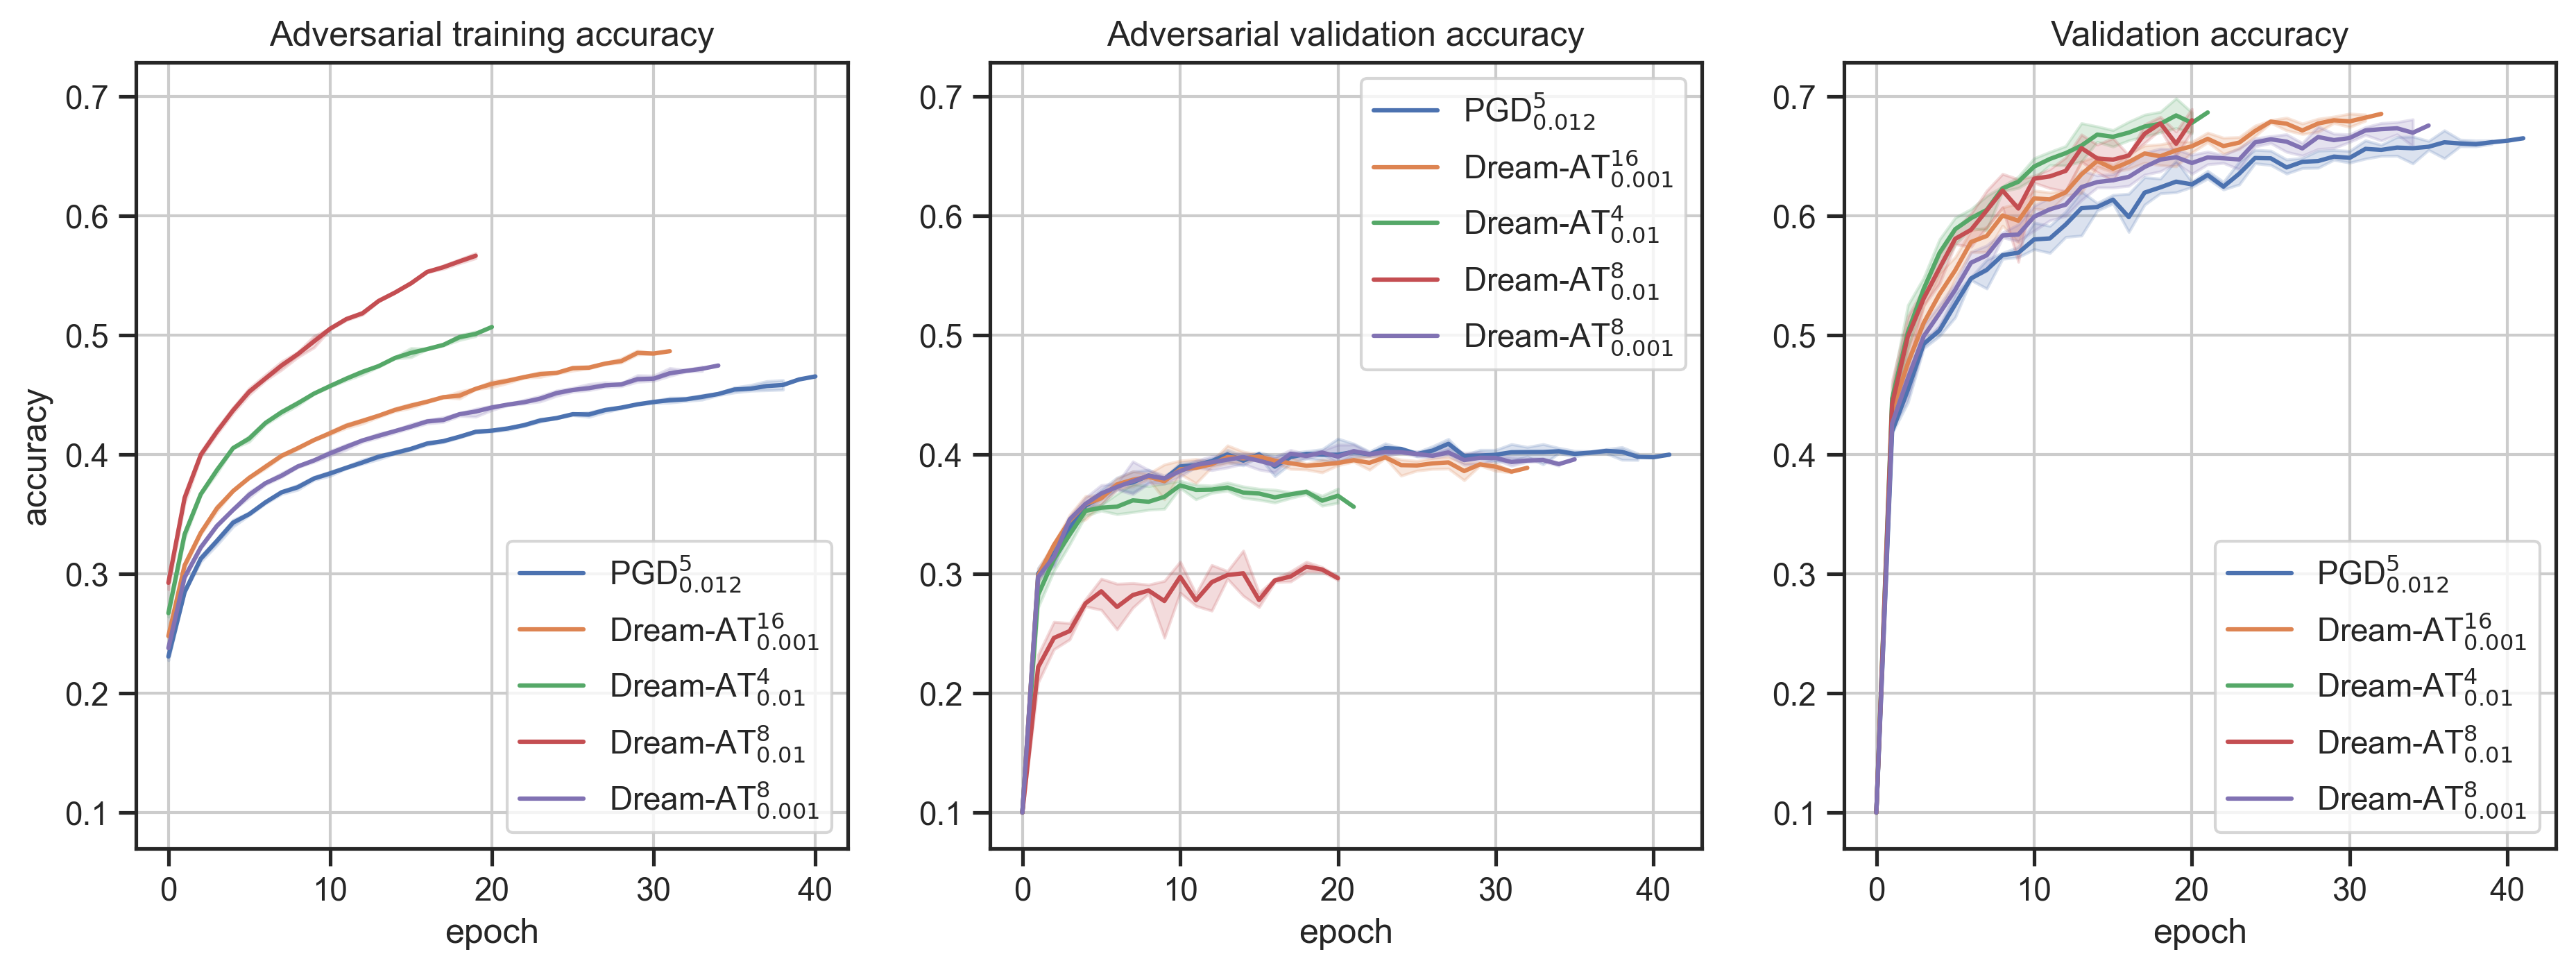

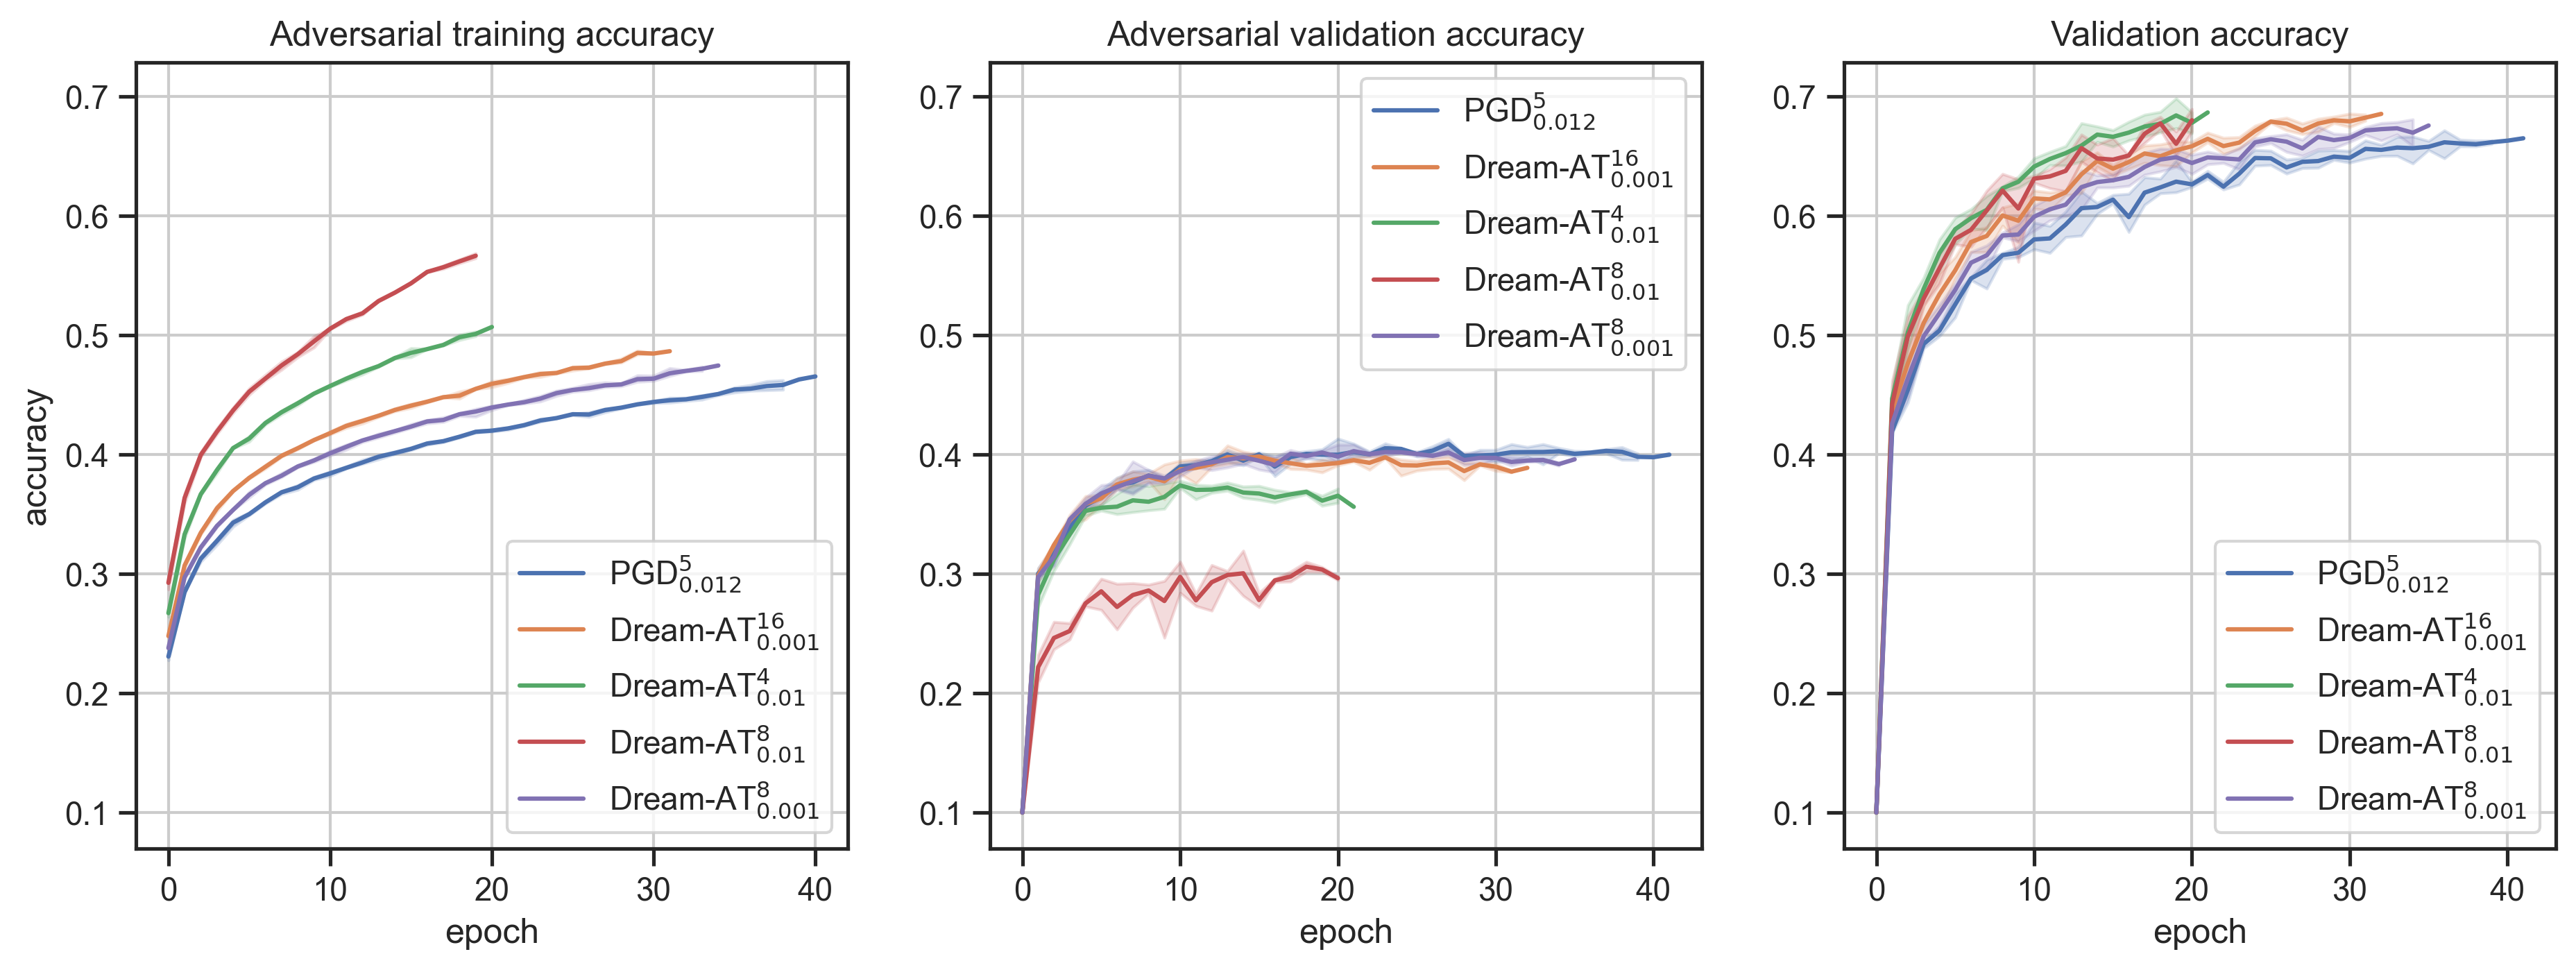

In [11]:
for _attack in df.attack.unique():
    plot_attack(df, _attack, conf_interval=('ci', 0), save_file=save_images)
    plot_attack(df, _attack, conf_interval=('ci', 95), save_file=save_images)
    plot_attack(df, _attack, conf_interval=lambda x: (x.min(), x.max()), save_file=save_images)

In [ ]:
timings = {}

for _att in df.attack.unique():
    timings[_att] = {}
    _at_df = df[df['attack'] == _att]
    
    for _mod in _at_df.model.unique():
        _mod_df = _at_df[_at_df['model'] == _mod]
        timings[_att][_mod] = {}

        for _vers in _mod_df.run.unique():
            timings[_att][_mod][_vers] = {}
            timings[_att][_mod][_vers]["val"] = []
            _val_inter = []
            _vdf = _mod_df[_mod_df["run"] == _vers]

            for _row in _vdf.iterrows():
                if _row[1].metric == "val_adv_acc":
                    timings[_att][_mod][_vers]["val"].append(_row[1].wall_time)


In [ ]:
# df.wall_time = pd.to_datetime(df.wall_time, unit='s')

In [ ]:
def get_acc_for(mdf, attack, model):
    _df = mdf[(mdf.attack == attack) & (mdf.model == model)]
    accs = {'adv' : [], 'reg': [] }
    for ver in _df.run.unique():
        _rundf = _df[_df.run == ver]
        adv_acc_row = _rundf[(_rundf.metric=="val_adv_acc") & (_rundf.value == _rundf[_rundf.metric=="val_adv_acc"].value.max())]
        # if adv_acc_row.epoch.count() > 1: 
        #     print(adv_acc_row.iloc[0].epoch)
        #     continue
        # else:
        epoch = adv_acc_row.iloc[0].epoch
        # print(epoch.item())
        val_acc_row = _rundf[(_rundf.metric=="val_acc") & (_rundf.epoch == epoch)]
        accs['adv'].extend(adv_acc_row.value) 
        accs['reg'].extend(val_acc_row.value) 
    return accs

In [ ]:

accs = get_acc_for(df, "CW20-0.1", "Dream-AT$_{0.001}^{16}$")

In [ ]:
diff_timings = {}
diff_timings['all'] = []
total_time = 0
total_epochs = 0

print(f"Attack vector & Dream parameters & Adv acc & val acc & mean training time per epoch & total training time")


for at, _mod in timings.items():
    diff_timings[at] = {}
    diff_timings[at]['all'] = []

    for mod, _ver in _mod.items():
        diff_timings[at][mod] = {}
        diffs = []


        for ver, vals in _ver.items():
            diff_timings[at][mod][ver] = []
            prev_val = vals['val'][0]
            curversiondiffs = []

            for val in vals['val']:
                diff = val - prev_val
                if diff > 0:
                    diffs.append(diff)
                    diff_timings[at][mod][ver].append(diff)
                    total_time += diff
                elif diff < 0: # Error - shouldn't happen
                    print(f"Diff <= 0, {diff:.5f}, epoch {len(diffs)} of {len(vals['val'])}")
                prev_val = val

        diff_timings[at][mod]['diffs'] = diffs.copy()
        diff_timings[at]['all'].extend(diffs.copy())
        diff_timings['all'].extend(diffs.copy())

        accs = get_acc_for(df, at, mod)
        _time_taken = np.sum(diffs)
        hours, rem = divmod(_time_taken, 3600)
        mins, secs = divmod(rem, 60)
        print(f"{style[at]} & {mod} & \\({np.mean(accs['adv'])*100:.1f} \\pm {np.std(accs['adv'])*100:.1f}\\% \\) & \\({np.mean(accs['reg'])*100:.1f} \\pm {np.std(accs['reg'])*100:.1f}\\%\\) &  \\({np.mean(diffs):.1f} \\pm {np.std(diffs):.1f}\\) & {hours:.0f}:{mins:2.0f}:{secs:.0f}\\\\")
        total_epochs += len(diffs)

    # print(f"For attack {at}: num epochs: {np.sum(len(diff_timings[at]['all']))}, mean epoch time = {np.mean(diff_timings[at]['all'])}, std = {np.std(diff_timings[at]['all'])}")


# all = [t for t in subl for subl in diff_timings['all']]
# all = [val for subl in diff_timings['all'] for val in subl]

# print(all)
print(f"All in all: {total_epochs} epochs, mean epoch time = {np.mean(diff_timings['all'])}")
print(f'Total training time for {dataset}: {pd.to_timedelta(total_epochs, unit="s")}')



In [ ]:
import json

with open(f"imgs/traintimes/{dataset}.json", 'w') as f:
    json.dump(diff_timings, f, indent=4)